In [1]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors as pltcolors
from datetime import datetime as dt

In [2]:
date_i_want = dt(2022, 6, 2)

In [3]:
elapseds = np.arange(np.timedelta64(0, 's'), np.timedelta64(10801, 's'), np.timedelta64(60, 's'))

In [4]:
ds = xr.open_dataset(f'/Volumes/LtgSSD/tobac_saves/tobac_Save_{date_i_want.strftime("%Y%m%d")}/seabreeze-obs.zarr')

/var/folders/sp/1j_lh9313dg42jrzhsfb4mk40000gn/T/ipykernel_70627/2567413497.py:1: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_dataset(f'/Volumes/LtgSSD/tobac_saves/tobac_Save_{date_i_want.strftime("%Y%m%d")}/seabreeze-obs.zarr')


In [5]:
all_tracks_interpd = xr.Dataset(
    coords={'track_elapsed' : elapseds, 'track_id' : ds.track.data},
    data_vars={
        'kdpvol' : (('track_id', 'track_elapsed'), np.full((len(ds.track.data), len(elapseds)), np.nan)),
        'zdrvol' : (('track_id', 'track_elapsed'), np.full((len(ds.track.data), len(elapseds)), np.nan)),
        'ltg' : (('track_id', 'track_elapsed'), np.full((len(ds.track.data), len(elapseds)), np.nan))
        }
)

In [6]:
all_tracks_interpd

<xarray.Dataset> Size: 3MB
Dimensions:        (track_id: 770, track_elapsed: 181)
Coordinates:
  * track_elapsed  (track_elapsed) timedelta64[s] 1kB 00:00:00 ... 03:00:00
  * track_id       (track_id) float64 6kB 0.0 1.0 2.0 3.0 ... 767.0 768.0 769.0
Data variables:
    kdpvol         (track_id, track_elapsed) float64 1MB nan nan nan ... nan nan
    zdrvol         (track_id, track_elapsed) float64 1MB nan nan nan ... nan nan
    ltg            (track_id, track_elapsed) float64 1MB nan nan nan ... nan nan

In [7]:
for i, this_track_id in enumerate(ds.track.data):
    track_ds = ds.sel(track=this_track_id)
    track_time_ds = track_ds.isel(time=(~np.isnan(track_ds.track_flash_count.data)),
                                feature=(track_ds.feature_parent_track_id.data == this_track_id),
                                cell=(track_ds.cell_parent_track_id.data == this_track_id))
    if track_time_ds.time.shape[0] == 0:
        continue
    track_elapsed = (track_time_ds.time - track_time_ds.time[0]).astype('timedelta64[s]')
    ds_to_interp = xr.Dataset(coords={'track_elapsed' : track_elapsed.data},
                        data_vars={
                            'kdpvol' : (('track_elapsed'), track_time_ds.track_kdpvol.data),
                            'zdrvol' : (('track_elapsed'), track_time_ds.track_zdrvol.data),
                            'ltg' : (('track_elapsed'), track_time_ds.track_flash_count.data)
                        })
    ds_to_interp = ds_to_interp.interp(track_elapsed=elapseds, method='linear')
    all_tracks_interpd.kdpvol[i] = ds_to_interp.kdpvol
    all_tracks_interpd.zdrvol[i] = ds_to_interp.zdrvol
    all_tracks_interpd.ltg[i] = ds_to_interp.ltg

In [8]:
to_rm = ~np.isnan(all_tracks_interpd.max(dim='track_elapsed')['kdpvol'].data)

In [9]:
all_tracks_interpd = all_tracks_interpd.isel(track_id=to_rm)

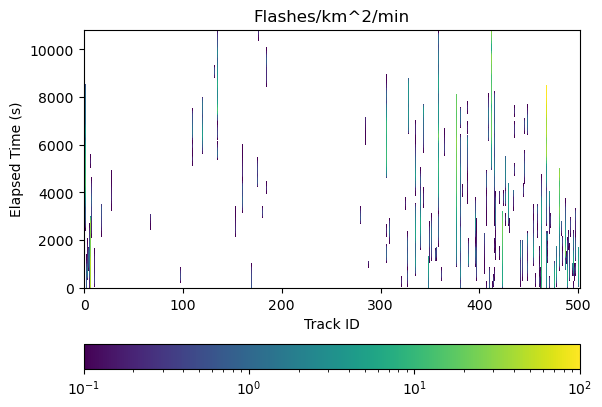

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('Track ID')
ax.set_ylabel('Elapsed Time (s)')
ax.set_title('Flashes/km^2/min')
c = ax.pcolormesh(np.arange(all_tracks_interpd.track_id.shape[0]), all_tracks_interpd.track_elapsed.astype(int), all_tracks_interpd.ltg.data.T, norm=pltcolors.LogNorm(vmin=.1, vmax=100), cmap='viridis')
plt.colorbar(c, orientation='horizontal')

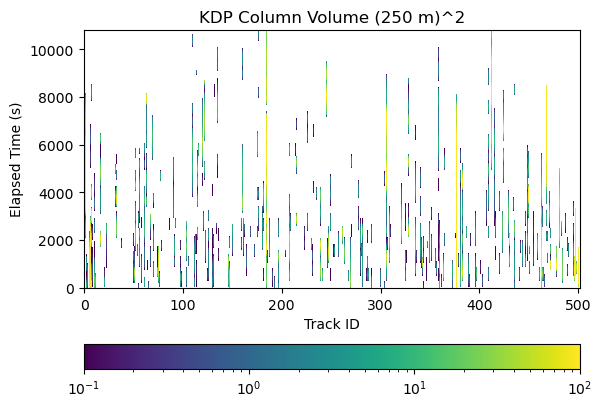

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('Track ID')
ax.set_ylabel('Elapsed Time (s)')
ax.set_title('KDP Column Volume (250 m)^2')
c = ax.pcolormesh(np.arange(all_tracks_interpd.track_id.shape[0]), all_tracks_interpd.track_elapsed.astype(int), all_tracks_interpd.kdpvol.data.T, norm=pltcolors.LogNorm(vmin=.1, vmax=100), cmap='viridis')
plt.colorbar(c, orientation='horizontal')

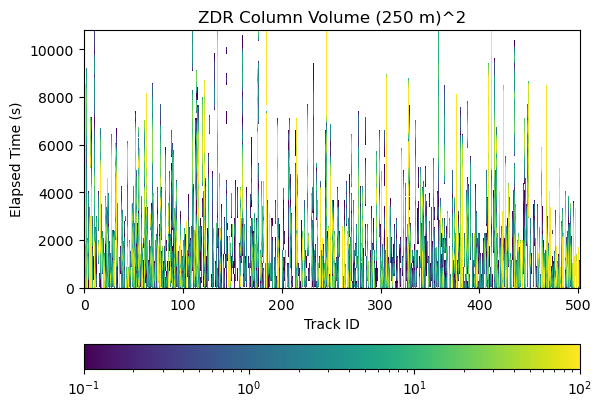

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('Track ID')
ax.set_ylabel('Elapsed Time (s)')
ax.set_title('ZDR Column Volume (250 m)^2')
c = ax.pcolormesh(np.arange(all_tracks_interpd.track_id.shape[0]), all_tracks_interpd.track_elapsed.astype(int), all_tracks_interpd.zdrvol.data.T, norm=pltcolors.LogNorm(vmin=.1, vmax=100), cmap='viridis')
plt.colorbar(c, orientation='horizontal')